In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from osgeo import ogr, osr
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from skimage.transform import resize
import hickle as hkl
from time import sleep

%run ../../src/downloading/utils.py
%run ../../src/models/utils.py

%matplotlib inline

In [2]:
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def convert_to_float(array):
    return (array.astype(float) / 65535)


def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):

    tl = point
    
    epsg = calculate_epsg(tl)
    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

In [11]:
OUTPUT_2019 = "../../tile_data/elsalvador-imposible/2019/output/"
OUTPUT_2018 = "../../tile_data/elsalvador-imposible/2018/output/"

In [12]:
max_x = 15
max_y = 15

start_x = 0
start_y = 0

pred_2019 = np.full(
    (
    (max_y-start_y)*126,
    (max_x-start_x)*126
    ), -1, dtype = np.float64 )

max_y_out = pred_2019.shape[0]
max_x_out = pred_2019.shape[1]

numb = 0
for row in range(start_y, max_y):
    for column in range(start_x, max_x):
        input_file = f"{OUTPUT_2019}{str(row)}/{str(column)}.npy"
        if os.path.exists(input_file):
            prediction = np.load(input_file)
            x_value = (column-start_x) *126
            y_value = (max_y_out - ((row - start_y + 1) *126))
            if (row % 5 == 0) and (column % 5 == 0):
                numb += 1
            pred_2019[y_value:y_value+126, 
                        x_value:x_value+126,
                        ] = prediction
#pred_2019[np.where(pred_2019 < 0.5)] = 0.

In [13]:
pred_2018 = np.full(
    (
    (max_y-start_y)*126,
    (max_x-start_x)*126
    ), -1, dtype = np.float64 )

max_y_out = pred_2018.shape[0]
max_x_out = pred_2018.shape[1]

numb = 0
for row in range(start_y, max_y):
    for column in range(start_x, max_x):
        input_file = f"{OUTPUT_2018}{str(row)}/{str(column)}.npy"
        if os.path.exists(input_file):
            prediction = np.load(input_file)
            x_value = (column-start_x) *126
            y_value = (max_y_out - ((row - start_y + 1) *126))
            if (row % 5 == 0) and (column % 5 == 0):
                numb += 1
            pred_2018[y_value:y_value+126, 
                        x_value:x_value+126,
                        ] = prediction
#pred_2018[np.where(pred_2018 < 0.5)] = 0.

In [14]:
change = pred_2019 - pred_2018
change[np.where(change < 0.4)] = 0.
change = change.reshape(change.shape[0] // 5, 5, change.shape[1] // 5, 5)
change = np.mean(change, axis = (1, 3))
change[np.where(change < 0.1)] = 0

In [15]:
len(np.argwhere(change.flatten() > 2*np.std(change.flatten()))) / len(change.flatten())

0.03927661599619271

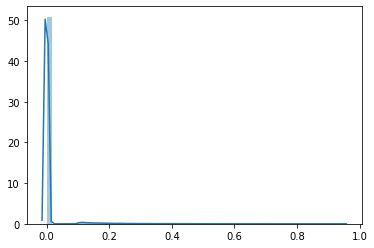

In [16]:
sns.distplot(change.flatten())

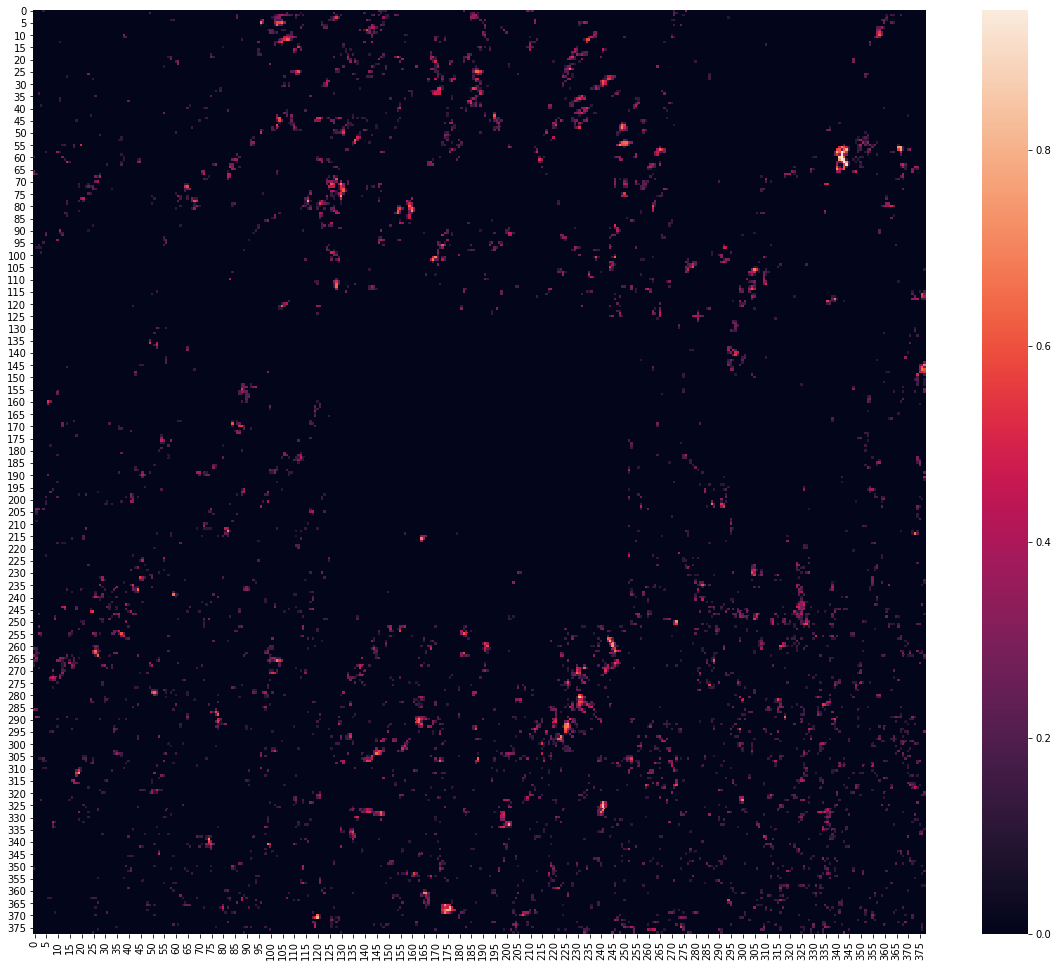

In [17]:
plt.figure(figsize=(20, 17))
sns.heatmap(change)

In [18]:
landscapes = {
    'ethiopia-tigray': (13.540810, 38.177220),
    'kenya-makueni-2': (-1.817109, 37.44563),
    'ghana': (9.259359, -0.83375),
    'niger-koure': (13.18158, 2.478),
    'cameroon-farnorth': (10.596, 14.2722),
    'botswana-kweneng': (-24.360968, 25.176526),
    'nicaragua-bonanza': (13.933745, -84.690842),
    'ghana-cocoa': (7.398111, -1.269223),
    'ghana-brong-ahafo': (7.70258, -0.70911),
    'mexico-change-det': (21.212083, -88.993677),
    'costa-rica-change-det': (8.47520, -82.94909),
    'mexico-yucatan': (21.062115, -88.998729),
    'honduras-colon': (15.617889, -85.447611),
    'mexico-campeche-change': (18.151747, -92.152278),
    'elsalvador-imposible': (13.727334, -90.015579),
    'guatemala-gain': (16.464444, -89.479170), 
    'guatemala-gain-2': (15.196480, -89.118290)
}

landscape = 'elsalvador-imposible'

coords = landscapes[landscape]
coords = (coords[1], coords[0])
point = bounding_box(coords, (max_x*1260)-160, ((max_y)*1260)-60, expansion = 0)
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]
print(max_y)

change = change.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = change.shape[1], height = change.shape[1])

print("Writing" + '../../../ce-hosting/includes/{}.tif'.format(landscape))
new_dataset = rasterio.open('../../../ce-hosting/includes/{}-gain.tif'.format(landscape), 'w', driver = 'GTiff',
                           height = change.shape[1], width = change.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(change, 1)
new_dataset.close()

15
Writing../../../ce-hosting/includes/elsalvador-imposible.tif
